### Pre-processing

In [7]:
from util import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

from scipy import stats
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from joblib import dump, load

In [11]:
data_log, data_dash = get_data_frames()
result_total, labels = get_data_concated(data_log, data_dash)

### Models

In [9]:
def train_rf_model(features_train: pd.DataFrame, labels_train: pd.Series):
    X_train, X_validation, y_train, y_validation = train_test_split(
        features_train,
        np.ravel(labels_train),
        test_size=0.20,
        random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    rf_model = RandomForestRegressor(
        n_estimators=140,
        max_depth=80,
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        verbose=1,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = cross_val_score(
        rf_model,
        X_train_scaled,
        y_train,
        cv=kf,
        scoring=mae_scorer
    )

    avg_cv_score = np.mean(cv_scores)

    rf_model.fit(X_train_scaled, y_train)

    y_pred_rf = rf_model.predict(X_validation_scaled)
    mae_rf = mean_absolute_error(y_validation, y_pred_rf)
    nmae_rf = mae_rf / np.mean(y_validation)

    feature_importances = rf_model.feature_importances_
    print(feature_importances)

    return nmae_rf, rf_model

### Train

In [10]:
nmae_rf, rf_model = train_rf_model(result_total, labels)
print(f"{nmae_rf*100:.4f}%")
alert_end()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parall

[0.08935992 0.09509435 0.08891935 0.06157569 0.00021631 0.02802903
 0.00028251 0.09837348 0.09045497 0.0611894  0.02128513 0.02691173
 0.02032025 0.08946929 0.09512341 0.06007301 0.02311468 0.02730816
 0.02289935]
28.2659%


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:    0.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50;, score=-6.440 total time=  11.7s
[CV 4/5] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50;, score=-6.415 total time=  13.1s
[CV 1/5] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50;, score=-6.449 total time=  14.3s
[CV 2/5] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50;, score=-6.359 total time=  14.4s
[CV 5/5] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50;, score=-6.484 total time=  11.8s
[CV 1/5] END regressor__max_depth=20, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=50;,

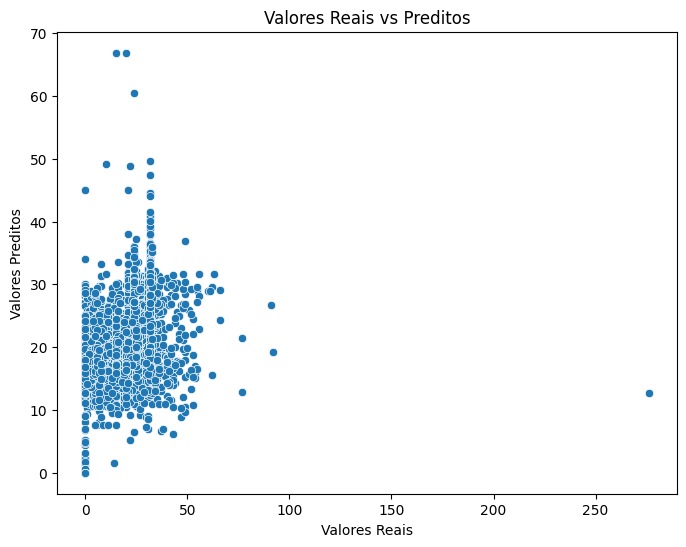

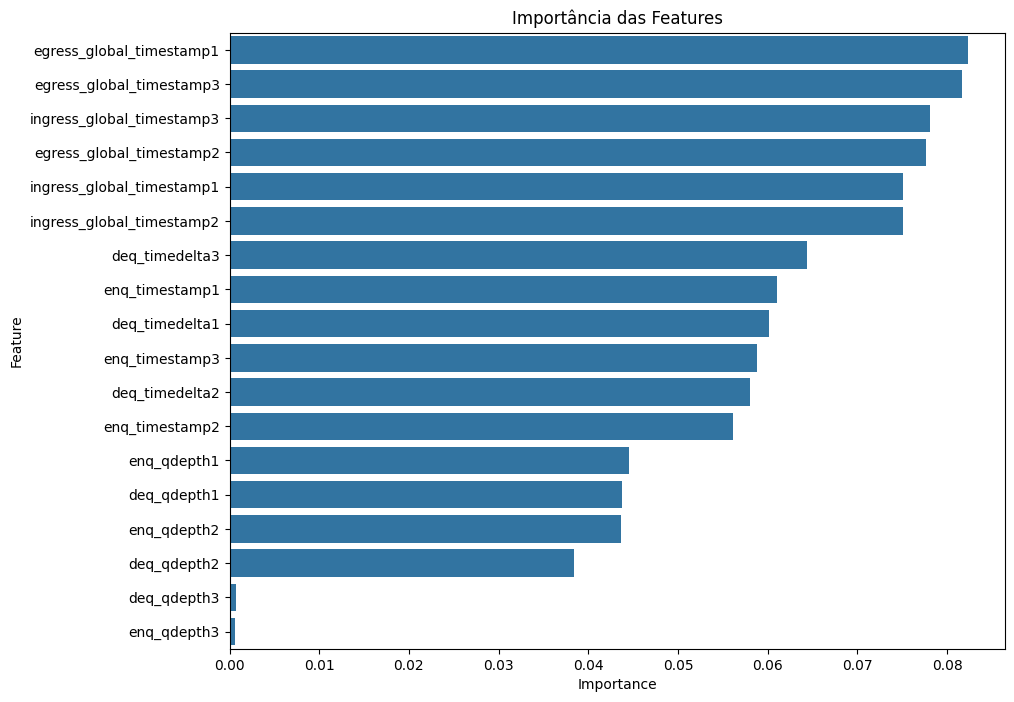

In [22]:
X = result_total
Y = labels

# Imputação e remoção de atributos com valores iguais
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

def remove_same_valued_attr(df):
    return df.loc[:, df.nunique() > 1]

X_imputed = remove_same_valued_attr(X_imputed)

# Dividindo os dados
X_train, X_eval, Y_train, Y_eval = train_test_split(
    X_imputed, Y, test_size=0.2, random_state=42
)

# Pipeline e RandomizedSearchCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_dist = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=kf,
    scoring='neg_mean_absolute_error',  # Alterado para MAE
    random_state=42,
    n_jobs=-1,
    verbose=3
)

random_search.fit(X_train, Y_train)

# Avaliação do modelo
best_model = random_search.best_estimator_

Y_pred = best_model.predict(X_eval)

# Cálculo do NMAE
mae = mean_absolute_error(Y_eval, Y_pred)
nmae = mae / Y_eval.mean()  # Normalizando pelo valor médio

print(f'Melhor modelo: {best_model}')
print(f'Mean Absolute Error na avaliação: {mae}')
print(f'Normalized Mean Absolute Error na avaliação: {nmae}')

# Visualizações
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_eval, y=Y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs Preditos')
plt.show()

importances = best_model.named_steps['regressor'].feature_importances_
feature_names = X_imputed.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Importância das Features')
plt.show()


MAE para esta divisão: 6.495452470641686
NMAE para esta divisão: 0.3226492185346968
MAE para esta divisão: 6.462178459151736
NMAE para esta divisão: 0.3220128509982021
MAE para esta divisão: 6.446151380215871
NMAE para esta divisão: 0.3296965921053116
MAE para esta divisão: 6.514254929054072
NMAE para esta divisão: 0.326683882021961
MAE para esta divisão: 6.369146811368552
NMAE para esta divisão: 0.32131938581220154
Mean Absolute Error médio em todas as divisões: 6.457436810086383


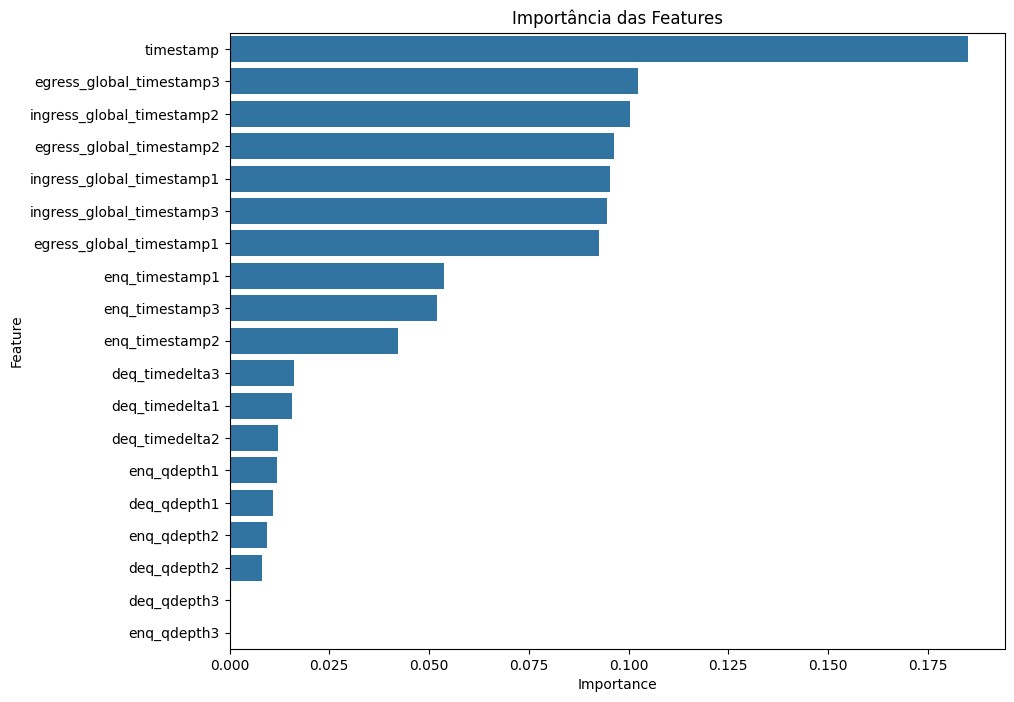

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

X = result_total
Y = labels

# Imputação e remoção de atributos com valores iguais
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

def remove_same_valued_attr(df):
    return df.loc[:, df.nunique() > 1]

X_imputed = remove_same_valued_attr(X_imputed)

# Dividindo os dados
X_train, X_eval, Y_train, Y_eval = train_test_split(
    X_imputed, Y, test_size=0.2, random_state=42
)

# Pipeline e RandomizedSearchCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

param_dist = {
    'regressor__n_estimators': [50, 100, 300],
    'regressor__max_depth': [ 5, 10, 50],
    'regressor__min_child_weight': [5, 10],
    'regressor__learning_rate': [0.01, 0.1],
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=kf,
    scoring='neg_mean_absolute_error',  # Alterado para MAE
    random_state=42,
    n_jobs=-1,
    verbose=3
)

random_search.fit(X_train, Y_train)

# Avaliação do modelo
best_model = random_search.best_estimator_

Y_pred = best_model.predict(X_eval)

# Cálculo do NMAE
mae = mean_absolute_error(Y_eval, Y_pred)
nmae = mae / Y_eval.mean()  # Normalizando pelo valor médio

print(f'Melhor modelo: {best_model}')
print(f'Mean Absolute Error na avaliação: {mae}')
print(f'Normalized Mean Absolute Error na avaliação: {nmae}')

# Visualizações
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_eval, y=Y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs Preditos')
plt.show()

importances = best_model.named_steps['regressor'].feature_importances_
feature_names = X_imputed.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Importância das Features')
plt.show()


MAE para esta divisão: 5.826755579601844
NMAE para esta divisão: 0.2894329752774705
MAE para esta divisão: 5.681119318669095
NMAE para esta divisão: 0.2830923720583439
MAE para esta divisão: 5.835453533846918
NMAE para esta divisão: 0.2984616758152827
MAE para esta divisão: 5.802806367021864
NMAE para esta divisão: 0.2910053922123255
MAE para esta divisão: 5.672699233143219
NMAE para esta divisão: 0.2861840506231428
Mean Absolute Error médio em todas as divisões: 5.763766806456589


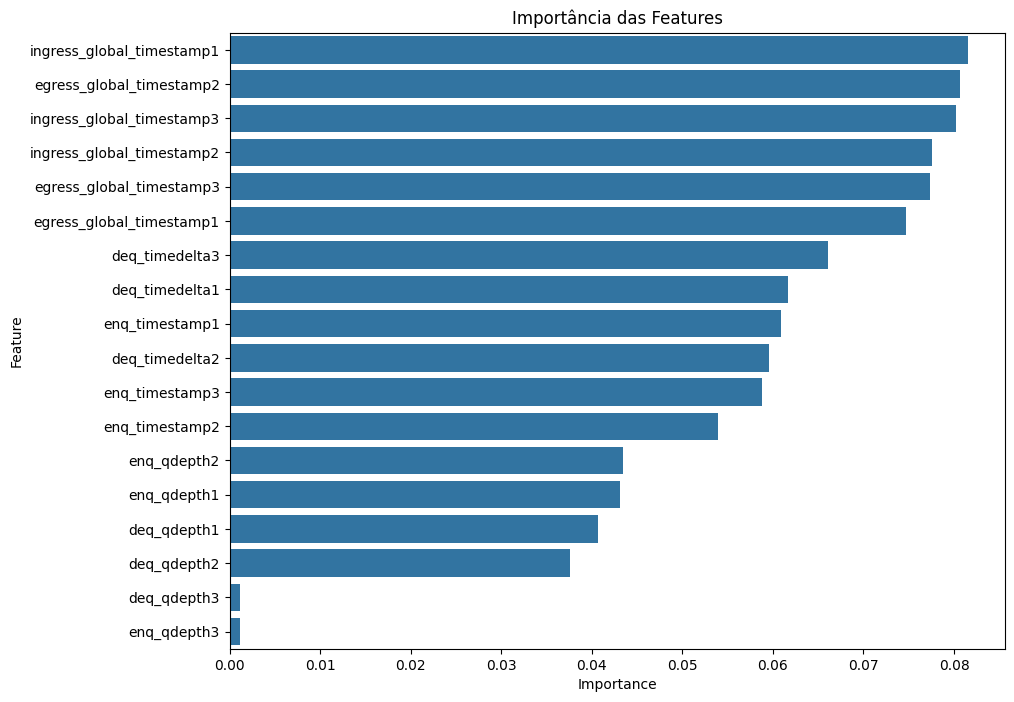

In [6]:
X = result_total
Y = labels

# Imputação e remoção de atributos com valores iguais
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

def remove_same_valued_attr(df):
    return df.loc[:, df.nunique() > 1]

X_imputed = remove_same_valued_attr(X_imputed)

X_imputed = X_imputed.drop(columns=['timestamp'])
# Pipeline com K-Fold manual
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(
        n_estimators=200, 
        max_depth=40, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        random_state=42,
        n_jobs=-1
    ))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []

# Loop para K-Fold
for train_index, test_index in kf.split(X_imputed):
    X_train, X_eval = X_imputed.iloc[train_index], X_imputed.iloc[test_index]
    Y_train, Y_eval = Y.iloc[train_index], Y.iloc[test_index]
    
    # Ajuste o pipeline no conjunto de treino
    pipeline.fit(X_train, Y_train)
    
    # Previsões no conjunto de avaliação
    Y_pred = pipeline.predict(X_eval)
    
    # Cálculo do MAE para esta divisão
    mae = mean_absolute_error(Y_eval, Y_pred)
    nmae = mae / Y_eval.mean()  # Normalizando pelo valor médio
    mae_scores.append(mae)
    
    print(f'MAE para esta divisão: {mae}')
    print(f'NMAE para esta divisão: {nmae}')

# Exibindo o MAE médio de todas as divisões
mean_mae = np.mean(mae_scores)
print(f'Mean Absolute Error médio em todas as divisões: {mean_mae}')

# Após o K-Fold, treine no conjunto completo e faça as previsões finais
pipeline.fit(X_imputed, Y)

# Importância das features
importances = pipeline.named_steps['regressor'].feature_importances_
feature_names = X_imputed.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Importância das Features')
plt.show()


In [7]:
X_imputed

,ingress_global_timestamp3,egress_global_timestamp3,enq_timestamp3,enq_qdepth3,deq_timedelta3,deq_qdepth3,ingress_global_timestamp2,egress_global_timestamp2,enq_timestamp2,enq_qdepth2,deq_timedelta2,deq_qdepth2,ingress_global_timestamp1,egress_global_timestamp1,enq_timestamp1,enq_qdepth1,deq_timedelta1,deq_qdepth1
0,3.909507e+10,3.909507e+10,4.403598e+08,0.00000,34.000000,0.000000,3.916932e+10,3.916932e+10,5.146125e+08,0.000000,34.000000,0.000000,3.924525e+10,3.924525e+10,5.905407e+08,0.000000,32.400000,0.000000
1,3.909580e+10,3.909580e+10,4.410972e+08,0.00000,26.333333,0.000000,3.917006e+10,3.917006e+10,5.153497e+08,0.000000,36.500000,0.000000,3.924598e+10,3.924598e+10,5.912778e+08,0.000000,30.333333,0.000000
2,3.909691e+10,3.909691e+10,4.422026e+08,0.00000,27.166667,0.000000,3.917116e+10,3.917116e+10,5.164553e+08,0.000000,26.000000,0.000000,3.924709e+10,3.924709e+10,5.923834e+08,0.000000,31.166667,0.000000
3,3.909790e+10,3.909790e+10,4.431917e+08,0.00000,28.142857,0.000000,3.917215e+10,3.917215e+10,5.174444e+08,0.000000,31.428571,0.000000,3.924808e+10,3.924808e+10,5.933725e+08,0.000000,28.285714,0.000000
4,3.909885e+10,3.909885e+10,4.441475e+08,0.00000,41.888889,0.000000,3.917311e+10,3.917311e+10,5.184002e+08,0.000000,31.777778,0.000000,3.924903e+10,3.924903e+10,5.943283e+08,0.000000,32.666667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32238,5.522485e+10,5.522485e+10,2.106121e+09,0.00764,120.203704,0.008169,5.529924e+10,5.529924e+10,2.111009e+09,0.757718,718.065258,0.572315,5.537510e+10,5.537510e+10,2.116211e+09,1.394736,959.173138,1.078428
32239,5.522485e+10,5.522485e+10,2.106121e+09,0.00764,120.203704,0.008169,5.529924e+10,5.529924e+10,2.111009e+09,0.757718,718.065258,0.572315,5.537510e+10,5.537510e+10,2.116211e+09,1.394736,959.173138,1.078428
32240,5.522485e+10,5.522485e+10,2.106121e+09,0.00764,120.203704,0.008169,5.529924e+10,5.529924e+10,2.111009e+09,0.757718,718.065258,0.572315,5.537510e+10,5.537510e+10,2.116211e+09,1.394736,959.173138,1.078428
32241,5.522485e+10,5.522485e+10,2.106121e+09,0.00764,120.203704,0.008169,5.529924e+10,5.529924e+10,2.111009e+09,0.757718,718.065258,0.572315,5.537510e+10,5.537510e+10,2.116211e+09,1.394736,959.173138,1.078428


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Função para calcular o NMAE (Normalized Mean Absolute Error)
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    return mae / np.mean(np.abs(y_true))

# 1. Remove valores NaN (tratamento de dados faltantes)
def removeNaN(data):
    return data.dropna()

# 2. Remove atributos com valores únicos (atributos sem variabilidade)
def removeSameValuedAttr(data):
    return data.loc[:, data.apply(pd.Series.nunique) > 1]

# 3. Normalização dos atributos (Z-score)
def normalize_data(data):
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)
    return pd.DataFrame(data_normalized, columns=data.columns)

# Carregar dados (substitua pelo seu dataset)
# df = pd.read_csv('seus_dados.csv')

# Etapas de pré-processamento
df_cleaned = removeNaN(result_total)  # Passo 1: Remove valores NaN
df_cleaned = removeSameValuedAttr(df_cleaned)  # Passo 2: Remove atributos sem variabilidade
df_normalized = normalize_data(df_cleaned)  # Passo 3: Normaliza os atributos

# Separar as features e o target (assumindo que a última coluna é o alvo)
X = df_normalized.iloc[:, :-1]
y = labels

# 4. Dividir os dados em treino/teste (80%) e avaliação (20%)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Executar validação cruzada K-Fold no conjunto de treino/teste (80%)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 6. Definir o espaço de busca para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Criar o modelo RandomForestRegressor
model = RandomForestRegressor()

# Realizar a busca aleatória usando RandomizedSearchCV com NMAE
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=25, cv=kf, random_state=42, scoring='neg_mean_absolute_error', verbose=3)
random_search.fit(X_train, y_train)

# Obter o melhor modelo e avaliar no conjunto de avaliação (20%)
best_model = random_search.best_estimator_
y_pred_eval = best_model.predict(X_eval)
nmae_eval = nmae(y_eval, y_pred_eval)

# Exibir os resultados
print(f"Melhor modelo: {best_model}")
print(f"NMAE na avaliação: {nmae_eval}")

# Opcional: Treinar e avaliar em diferentes cargas, se aplicável
# Repita o processo se for necessário carregar e processar vários conjuntos de dados


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=-7.077 total time= 1.1min
[CV 2/5] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=-6.840 total time= 1.1min
[CV 3/5] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=-6.835 total time= 1.1min
[CV 4/5] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=-6.954 total time= 1.2min
[CV 5/5] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=-7.113 total time= 1.1min
[CV 1/5] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=-6.786 total time=  60.0s
[CV 2/5] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=-6.683 tot

<img src='./images/output.png'>